### Importing the Libraries and Packages ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

plt.style.use("bmh")
plt.rcParams['font.family'] = 'Trebuchet MS'
import warnings

In [2]:
from datetime import datetime as dt
import pandas_profiling
from pandas_profiling import ProfileReport 
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from math import sqrt
import tensorflow.compat.v2 as tf
from tensorflow.python.platform import tf_logging as logging
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.distribute import sidecar_evaluator
from keras import distribute
from keras import models
from keras.engine.input_layer import Input
from keras import Sequential
import pickle

C:\Users\fatim\AppData\Local\Temp\ipykernel_15316\1823406283.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


### Loading the Datasets ### 

In [3]:
train=pd.read_csv('data/train.csv',parse_dates=['Date'])
features=pd.read_csv('data/features.csv',parse_dates=['Date'])
stores=pd.read_csv('data/stores.csv')

### Merge "features"  and "stores", then view the first 5 rows for a Brief insight into the resulting dataset ###

In [4]:
df1=pd.merge(features,stores,on=['Store'])
df1.head()

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type    Size  
0        NaN        NaN  211.096358         8.106      False    A  151315  
1        NaN        NaN  211.242170         8.106       True    A  151315  
2        NaN        NaN  211.289143         8.106      False    A  151315  
3        NaN        NaN  211.319643         8.106      False    A  151315  
4        NaN        NaN  211.350143         8.106      False    A  151315

### View the basic information ###

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
 12  Type          8190 non-null   object        
 13  Size          8190 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 903.8+ KB


### Data Pre-processing ###

In [6]:
#Drop the MarkDown Columns, due to the predominant null va;ues
df1.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1,inplace=True)

In [7]:
#View the top five rows for a brief insight
df1.head()

Store       Date  Temperature  Fuel_Price         CPI  Unemployment  \
0      1 2010-02-05        42.31       2.572  211.096358         8.106   
1      1 2010-02-12        38.51       2.548  211.242170         8.106   
2      1 2010-02-19        39.93       2.514  211.289143         8.106   
3      1 2010-02-26        46.63       2.561  211.319643         8.106   
4      1 2010-03-05        46.50       2.625  211.350143         8.106   

   IsHoliday Type    Size  
0      False    A  151315  
1       True    A  151315  
2      False    A  151315  
3      False    A  151315  
4      False    A  151315

### Save the resulting dataset as a csv file as "merged_features" into the "output" folder ###

In [8]:
df1.to_csv('output/merged_features.csv',index=False)

### Merge the "train" data with the merged "features and stores" datasets ###

In [9]:
data=pd.merge(train,df1,on=['Date','Store','IsHoliday'])
data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     2 2010-02-05      50605.27      False        42.31       2.572   
2      1     3 2010-02-05      13740.12      False        42.31       2.572   
3      1     4 2010-02-05      39954.04      False        42.31       2.572   
4      1     5 2010-02-05      32229.38      False        42.31       2.572   

          CPI  Unemployment Type    Size  
0  211.096358         8.106    A  151315  
1  211.096358         8.106    A  151315  
2  211.096358         8.106    A  151315  
3  211.096358         8.106    A  151315  
4  211.096358         8.106    A  151315

In [10]:
#View the dimension of the dataframe
data.shape

(421570, 11)

In [11]:
#Display the number of unique values for each column
data.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
Temperature       3528
Fuel_Price         892
CPI               2145
Unemployment       349
Type                 3
Size                40
dtype: int64

### Pre-process the date column ###

In [12]:
y=[]
m=[]
d=[]
for dt in data['Date']:
    y.append(dt.year)
    m.append(dt.month)
    d.append(dt.day)

In [13]:
data['Year'] = pd.Series(y)
data['Month'] = pd.Series(m)
data['Day'] = pd.Series(d)

In [14]:
data.drop('Date',axis=1,inplace=True)

#### View the top five rows for a brief insight ####

In [15]:
data.head()

Store  Dept  Weekly_Sales  IsHoliday  Temperature  Fuel_Price         CPI  \
0      1     1      24924.50      False        42.31       2.572  211.096358   
1      1     2      50605.27      False        42.31       2.572  211.096358   
2      1     3      13740.12      False        42.31       2.572  211.096358   
3      1     4      39954.04      False        42.31       2.572  211.096358   
4      1     5      32229.38      False        42.31       2.572  211.096358   

   Unemployment Type    Size  Year  Month  Day  
0         8.106    A  151315  2010      2    5  
1         8.106    A  151315  2010      2    5  
2         8.106    A  151315  2010      2    5  
3         8.106    A  151315  2010      2    5  
4         8.106    A  151315  2010      2    5

In [16]:
# For a more robust exploratory analysis
report = ProfileReport(data)
data.profile_report()
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Creating a list of column names is generated in the DataFrame `data` that have numeric data types, which are either `float64`, `int64`, `float32`, or `int32` by iterating over the dictionary `dict(data.dtypes)` containing column names and their corresponding data types, and adding the column names with numeric data types to the `numeric_var_names` list using a list comprehension.
numeric_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Creating a list of column names that have a categorical data type in the DataFrame `data
cat_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object', 'O','bool']]

In [18]:
# Calling the nimeric variables
numeric_var_names

['Store',
 'Dept',
 'Weekly_Sales',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'Size',
 'Year',
 'Month',
 'Day']

In [19]:
# Calling the categorical variables
cat_var_names  

['IsHoliday', 'Type']

In [20]:
 #Displaying the first few columns
data_num=data[numeric_var_names]
data_num.head(5)

Store  Dept  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0      1     1      24924.50        42.31       2.572  211.096358   
1      1     2      50605.27        42.31       2.572  211.096358   
2      1     3      13740.12        42.31       2.572  211.096358   
3      1     4      39954.04        42.31       2.572  211.096358   
4      1     5      32229.38        42.31       2.572  211.096358   

   Unemployment    Size  Year  Month  Day  
0         8.106  151315  2010      2    5  
1         8.106  151315  2010      2    5  
2         8.106  151315  2010      2    5  
3         8.106  151315  2010      2    5  
4         8.106  151315  2010      2    5

In [21]:
# Replace negative and 0 as missing
pd.set_option('mode.chained_assignment', None) # For SettingWithCopyWarning
data_num[data_num<=0]=np.NaN

In [22]:
data_cat=data[cat_var_names]
data_cat.head(5)

IsHoliday Type
0      False    A
1      False    A
2      False    A
3      False    A
4      False    A

### Data Audit Report

In [23]:
# Creating Data audit Report
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.std()/x.mean(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'CV','MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

data_num.apply(var_summary).T

N   NMISS           SUM           MEAN        MEDIAN  \
Store         421570.0     0.0  9.359084e+06      22.200546      22.00000   
Dept          421570.0     0.0  1.865882e+07      44.260317      37.00000   
Weekly_Sales  420212.0  1358.0  6.737307e+09   16033.114591    7661.70000   
Temperature   421501.0    69.0  2.533231e+07      60.100233      62.09000   
Fuel_Price    421570.0     0.0  1.416908e+06       3.361027       3.45200   
CPI           421570.0     0.0  7.217360e+07     171.201947     182.31878   
Unemployment  421570.0     0.0  3.355819e+06       7.960289       7.86600   
Size          421570.0     0.0  5.764039e+10  136727.915739  140167.00000   
Year          421570.0     0.0  8.477640e+08    2010.968591    2011.00000   
Month         421570.0     0.0  2.718920e+06       6.449510       6.00000   
Day           421570.0     0.0  6.607322e+06      15.673131      16.00000   

                       STD           VAR        CV        MIN            P1  \
Store            12.785297  1.634638e+02  0.575900      1.000      1.000000   
Dept             30.492054  9.297654e+02  0.688925      1.000      1.000000   
Weekly_Sales  22729.492116  5.166298e+08  1.417659      0.010      7.440000   
Temperature      18.432294  3.397495e+02  0.306693      5.540     18.360000   
Fuel_Price        0.458515  2.102356e-01  0.136421      2.472      2.565000   
CPI              39.159276  1.533449e+03  0.228731    126.064    126.111903   
Unemployment      1.863296  3.471872e+00  0.234074      3.879      4.156000   
Size          60980.583328  3.718632e+09  0.446000  34875.000  34875.000000   
Year              0.796876  6.350114e-01  0.000396   2010.000   2010.000000   
Month             3.243217  1.051846e+01  0.502863      1.000      1.000000   
Day               8.753549  7.662462e+01  0.558507      1.000      1.000000   

                        P5           P10           P25           P50  \
Store             3.000000      5.000000     11.000000      22.00000   
Dept              4.000000      7.000000     18.000000      37.00000   
Weekly_Sales     67.551000    311.186000   2120.130000    7661.70000   
Temperature      27.310000     33.990000     46.700000      62.09000   
Fuel_Price        2.653000      2.720000      2.933000       3.45200   
CPI             126.496258    128.823806    132.022667     182.31878   
Unemployment      5.326000      5.965000      6.891000       7.86600   
Size          39690.000000  39910.000000  93638.000000  140167.00000   
Year           2010.000000   2010.000000   2010.000000    2011.00000   
Month             1.000000      2.000000      4.000000       6.00000   
Day               2.000000      4.000000      8.000000      16.00000   

                        P75            P90            P95            P99  \
Store             33.000000      40.000000      43.000000      45.000000   
Dept              74.000000      92.000000      95.000000      98.000000   
Weekly_Sales   20271.265000   42922.748000   61275.522000  106566.351400   
Temperature       74.280000      83.580000      87.270000      92.810000   
Fuel_Price         3.738000       3.917000       4.029000       4.202000   
CPI              212.416993     219.444244     221.941558     225.473509   
Unemployment       8.572000       9.816000      12.187000      14.180000   
Size          202505.000000  204184.000000  206302.000000  219622.000000   
Year            2012.000000    2012.000000    2012.000000    2012.000000   
Month              9.000000      11.000000      12.000000      12.000000   
Day               23.000000      28.000000      29.000000      31.000000   

                        MAX  
Store             45.000000  
Dept              99.000000  
Weekly_Sales  693099.360000  
Temperature      100.140000  
Fuel_Price         4.468000  
CPI              227.232807  
Unemployment      14.313000  
Size          219622.000000  
Year            2012.000000  
Month             12.000000  
Day               31.000000

In [24]:
num_summary=data_num.apply(var_summary).T
num_summary.to_csv('output/num_summary.csv')  #save the numeric features

In [25]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=data_cat.apply(cat_summary)

In [26]:
cat_summary

IsHoliday  \
N                                                        421570   
NMISS                                                         0   
ColumnsNames  False    391909
True      29661
Name: IsHolida...   

                                                           Type  
N                                                        421570  
NMISS                                                         0  
ColumnsNames  A    215478
B    163495
C     42597
Name: Type...

### Handling Outlier

In [27]:
#Handling Outliers
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

data_num=data_num.apply(outlier_capping)

### Handling Missing

In [28]:
#Handling missings
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data_num=data_num.apply(Missing_imputation)

### Dummy Creation

In [29]:
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [30]:
for c_feature in ['IsHoliday', 'Type']:
    data_cat.loc[:,c_feature] = data_cat[c_feature].astype('category')
    data_cat = create_dummies(data_cat , c_feature )
    
data_cat.head()

C:\Users\fatim\AppData\Local\Temp\ipykernel_15316\1144814179.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_cat.loc[:,c_feature] = data_cat[c_feature].astype('category')


IsHoliday_True  Type_B  Type_C
0               0       0       0
1               0       0       0
2               0       0       0
3               0       0       0
4               0       0       0

### Final file for analysis

In [31]:
data = pd.concat([data_num, data_cat], axis=1)
data.head()

Store  Dept  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0      1     1      24924.50        42.31       2.572  211.096358   
1      1     2      50605.27        42.31       2.572  211.096358   
2      1     3      13740.12        42.31       2.572  211.096358   
3      1     4      39954.04        42.31       2.572  211.096358   
4      1     5      32229.38        42.31       2.572  211.096358   

   Unemployment    Size  Year  Month  Day  IsHoliday_True  Type_B  Type_C  
0         8.106  151315  2010      2    5               0       0       0  
1         8.106  151315  2010      2    5               0       0       0  
2         8.106  151315  2010      2    5               0       0       0  
3         8.106  151315  2010      2    5               0       0       0  
4         8.106  151315  2010      2    5               0       0       0

In [32]:
# correlation matrix (ranges from 1 to -1)
corrm=data.corr()
corrm.to_csv('output/correl_matr.csv')
corrm

Store      Dept  Weekly_Sales  Temperature  Fuel_Price  \
Store           1.000000  0.024011     -0.083732    -0.052251    0.064984   
Dept            0.024011  1.000000      0.143319     0.004383    0.003514   
Weekly_Sales   -0.083732  0.143319      1.000000     0.000576    0.001502   
Temperature    -0.052251  0.004383      0.000576     1.000000    0.142011   
Fuel_Price      0.064984  0.003514      0.001502     0.142011    1.000000   
CPI            -0.210949 -0.007483     -0.022807     0.184608   -0.162609   
Unemployment    0.208671  0.007874     -0.025323     0.095511   -0.034938   
Size           -0.182881 -0.003022      0.252590    -0.059287    0.004468   
Year            0.002997  0.003688     -0.009287     0.066476    0.780315   
Month           0.001011  0.000894      0.025578     0.234499   -0.042186   
Day            -0.000015 -0.000664     -0.007982     0.025848    0.028013   
IsHoliday_True -0.000548  0.000906      0.007948    -0.156730   -0.077839   
Type_B         -0.233461 -0.029920     -0.134705    -0.107740    0.037372   
Type_C          0.439004  0.028344     -0.099054     0.135709    0.001369   

                     CPI  Unemployment      Size      Year     Month  \
Store          -0.210949      0.208671 -0.182881  0.002997  0.001011   
Dept           -0.007483      0.007874 -0.003022  0.003688  0.000894   
Weekly_Sales   -0.022807     -0.025323  0.252590 -0.009287  0.025578   
Temperature     0.184608      0.095511 -0.059287  0.066476  0.234499   
Fuel_Price     -0.162609     -0.034938  0.004468  0.780315 -0.042186   
CPI             1.000000     -0.300190 -0.003307  0.074335  0.005130   
Unemployment   -0.300190      1.000000 -0.068099 -0.236754 -0.012963   
Size           -0.003307     -0.068099  1.000000 -0.004975 -0.001210   
Year            0.074335     -0.236754 -0.004975  1.000000 -0.194288   
Month           0.005130     -0.012963 -0.001210 -0.194288  1.000000   
Day             0.002701     -0.003802 -0.000386  0.005835  0.016363   
IsHoliday_True -0.001934      0.010305  0.000593 -0.056746  0.123376   
Type_B         -0.081883     -0.013574 -0.455646 -0.000732  0.000019   
Type_C         -0.006557      0.175291 -0.528852  0.005244 -0.000092   

                     Day  IsHoliday_True    Type_B    Type_C  
Store          -0.000015       -0.000548 -0.233461  0.439004  
Dept           -0.000664        0.000906 -0.029920  0.028344  
Weekly_Sales   -0.007982        0.007948 -0.134705 -0.099054  
Temperature     0.025848       -0.156730 -0.107740  0.135709  
Fuel_Price      0.028013       -0.077839  0.037372  0.001369  
CPI             0.002701       -0.001934 -0.081883 -0.006557  
Unemployment   -0.003802        0.010305 -0.013574  0.175291  
Size           -0.000386        0.000593 -0.455646 -0.528852  
Year            0.005835       -0.056746 -0.000732  0.005244  
Month           0.016363        0.123376  0.000019 -0.000092  
Day             1.000000        0.045465  0.000503 -0.000098  
IsHoliday_True  0.045465        1.000000  0.000167 -0.001017  
Type_B          0.000503        0.000167  1.000000 -0.266848  
Type_C         -0.000098       -0.001017 -0.266848  1.000000

<Axes: >

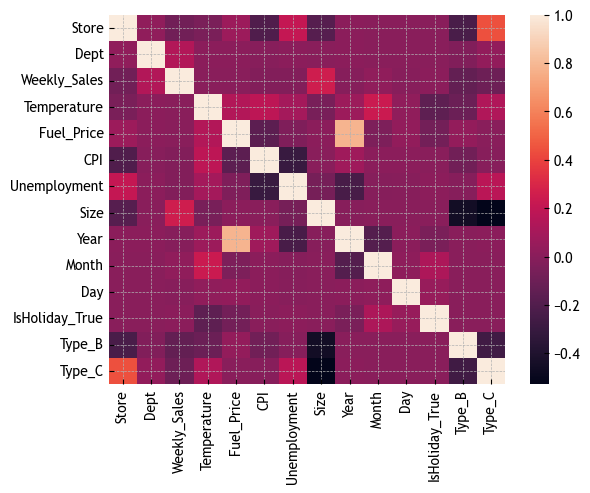

In [33]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(data.corr())

In [34]:
data.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Size', 'Year', 'Month', 'Day', 'IsHoliday_True',
       'Type_B', 'Type_C'],
      dtype='object')

### Model Building

In [35]:
lm=smf.ols('Weekly_Sales~Store+Dept+Temperature+Fuel_Price+CPI+Unemployment+Size+Year+Month+Day+IsHoliday_True++Type_C', data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     3565.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        09:55:54   Log-Likelihood:            -4.7688e+06
No. Observations:              421570   AIC:                         9.538e+06
Df Residuals:                  421557   BIC:                         9.538e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6.153e+05   1.41e+05      4.

In [36]:
data.drop('Type_B',axis=1,inplace=True)

In [37]:
X=data[data.columns.difference(['Weekly_Sales'])]
y=data['Weekly_Sales']

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree

In [39]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_predict

In [40]:
regressor = DecisionTreeRegressor(max_depth=5,random_state=0)  
regressor.fit(X_train, y_train) 

DecisionTreeRegressor(max_depth=5, random_state=0)

In [41]:
pred=regressor.predict(X_train)
y_pred=regressor.predict(X_test)

In [42]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 9113.460578665334
Mean Squared Error: 191174213.57522035
Root Mean Squared Error: 13826.57635046436


In [43]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 9186.836180673572
Mean Squared Error: 194877398.09940347
Root Mean Squared Error: 13959.84950131639


In [44]:
from sklearn.metrics import r2_score

print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.554622672271602
R-squared for Test: 0.5536357417116555


### Tuning a regression tree

In [45]:
# list of values to try
max_depth_range = range(5, 15)

# list to store the average RMSE for each value of max_depth
RMSE_Scores = []
MSE_Scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=345)
    
    MSE_scores = cross_val_score(treereg, X_train, y_train, scoring='neg_mean_squared_error')
    
    RMSE_Scores.append(np.mean(np.sqrt(-MSE_scores)))
    MSE_Scores.append(MSE_scores)

In [46]:
print (RMSE_Scores)

[13839.563750819128, 11035.00005933862, 10037.339197583042, 9097.817721160429, 8245.632372141445, 7316.492038669663, 6486.01459274646, 5818.989256364759, 5246.998235599979, 4772.227860374315]


Text(0, 0.5, 'RMSE (lower is better)')

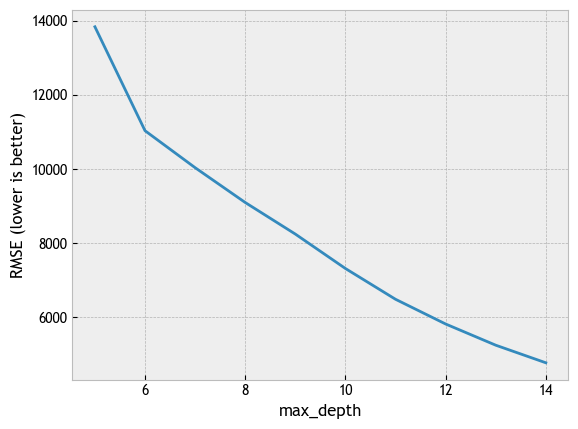

In [47]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_Scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

### Building Final Decision Tree Model

In [48]:
# max_depth=11 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=14, random_state=345)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=14, random_state=345)

In [49]:
treereg.feature_importances_

array([2.15161273e-02, 7.00173109e-03, 6.83762807e-01, 1.34506791e-03,
       1.41407305e-03, 1.62103972e-02, 1.89654576e-01, 5.53134305e-02,
       5.49503510e-03, 1.20822802e-02, 5.83233067e-03, 3.72144008e-04])

In [50]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':data.columns.difference(['Weekly_Sales']), 'importance':treereg.feature_importances_})

feature  importance
0              CPI    0.021516
1              Day    0.007002
2             Dept    0.683763
3       Fuel_Price    0.001345
4   IsHoliday_True    0.001414
5            Month    0.016210
6             Size    0.189655
7            Store    0.055313
8      Temperature    0.005495
9           Type_C    0.012082
10    Unemployment    0.005832
11            Year    0.000372

## Creating a tree diagram

In [51]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_vehicles.png', feature_names=data.columns.difference(['Weekly_Sales']))

## Making predictions

In [52]:
pred=treereg.predict(X_train)
y_pred=treereg.predict(X_test)

In [53]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 2069.975191151128
Mean Squared Error: 16407973.30071376
Root Mean Squared Error: 4050.6756597774847


In [54]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 2372.1798919405896
Mean Squared Error: 21558679.737708703
Root Mean Squared Error: 4643.132535014342


In [55]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.9617744508244808
R-squared for Test: 0.9506201120055504


# Random Forest (RF)

In [56]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
rfr = RandomForestRegressor(max_depth=5,n_estimators=20, random_state=0)  
rfr.fit(X_train, y_train)  
pred = rfr.predict(X_train) 

In [58]:
y_pred= rfr.predict(X_test)

In [59]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 9112.008923160754
Mean Squared Error: 191091445.083154
Root Mean Squared Error: 13823.582932190699


In [60]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 9185.46851970489
Mean Squared Error: 194781616.3495224
Root Mean Squared Error: 13956.418464259461


In [61]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.5548154974917361
R-squared for Test: 0.5538551286193225


### Tuning a Random Forest

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
param_grid={'max_depth': range(8,15),
            'n_estimators': (10, 50)}

In [64]:
# Perform Grid-Search
gsc = GridSearchCV(estimator=RandomForestRegressor(),param_grid=param_grid, verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)

In [65]:
grid_result.best_score_

0.9604172908339971

In [66]:
grid_result.best_params_

{'max_depth': 14, 'n_estimators': 50}

### Building Final Random Forest Model

In [67]:
rfr = RandomForestRegressor(max_depth=14,n_estimators=50, random_state=0)
rfr.fit(X_train, y_train) 

RandomForestRegressor(max_depth=14, n_estimators=50, random_state=0)

In [68]:
pred = rfr.predict(X_train)
y_pred = rfr.predict(X_test)

In [69]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 1914.5495257983994
Mean Squared Error: 13191916.058545472
Root Mean Squared Error: 3632.0677387055257


In [70]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 2139.863327973507
Mean Squared Error: 16850922.20069006
Root Mean Squared Error: 4104.9874787494855


In [71]:
from sklearn.metrics import r2_score

print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.9692668785612105
R-squared for Test: 0.9614031721331329


# Gradient Boosting (GBM)

In [72]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit

In [73]:
gbrt=GradientBoostingRegressor()
gbrt.fit(X_train, y_train)

GradientBoostingRegressor()

In [74]:
pred=gbrt.predict(X_train)
y_pred=gbrt.predict(X_test)

In [75]:
#One of the benefits of growing trees is that we can understand how important each of the features are
print(gbrt.feature_importances_)

[1.09856812e-02 5.36147321e-04 7.51437878e-01 1.04415965e-06
 2.07666801e-04 2.38718421e-03 1.99210102e-01 2.90507155e-02
 4.23591299e-04 4.90473107e-03 8.26020113e-04 2.92381134e-05]


In [76]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 6551.714582016239
Mean Squared Error: 100815080.85690083
Root Mean Squared Error: 10040.671334970626


In [77]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 6622.518007051184
Mean Squared Error: 104317195.93169284
Root Mean Squared Error: 10213.578997182762


In [78]:
from sklearn.metrics import r2_score

print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.7651317587918206
R-squared for Test: 0.7610627592378938


### Tuning a Gradient Boosting Model (GBM)

In [79]:
param_grid={'learning_rate' : [0.1,0.01],# 0.02,0.05,0.1],
            'max_depth' : [4,6]}# 5,6]

In [80]:
# Perform Grid-Search
gbr = GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=param_grid)
    
grid_result = gbr.fit(X_train, y_train)

In [81]:
grid_result.best_score_

0.9114080177767148

In [82]:
grid_result.best_params_

{'learning_rate': 0.1, 'max_depth': 6}

### Building Final Gradient Boosting Model

In [83]:
gbrt=GradientBoostingRegressor(learning_rate=0.01, max_depth=6)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=6)

In [84]:
pred=gbrt.predict(X_train)
y_pred=gbrt.predict(X_test)

In [85]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 8757.334746550901
Mean Squared Error: 156533706.6138548
Root Mean Squared Error: 12511.343117901242


In [86]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 8840.985051279675
Mean Squared Error: 161696310.42731225
Root Mean Squared Error: 12715.986411887685


In [87]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.6353244370812139
R-squared for Test: 0.6296366106292443


# XGBOOST

In [88]:
import xgboost as xgb
import warnings

In [89]:
warnings.filterwarnings("ignore", category=FutureWarning)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [90]:
pred=xg_reg.predict(X_train)
y_pred=xg_reg.predict(X_test)

In [91]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 2824.3421021008785
Mean Squared Error: 21272414.339624897
Root Mean Squared Error: 4612.2027643659485


In [92]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 2898.663189984219
Mean Squared Error: 22869686.713171575
Root Mean Squared Error: 4782.226125265468


In [93]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.9504417940279084
R-squared for Test: 0.9476172668222683


### Tuning a XGBoost Model

In [94]:
xgb1 = xgb.XGBRegressor(objective='reg:squarederror')

In [95]:
parameters = {'learning_rate': [0.01,0.1], #so called `eta` value
              'max_depth': [4,5,6]}

In [96]:
xgb_grid = GridSearchCV(xgb1,parameters,n_jobs = 5,verbose=True)

grid_result = xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [97]:
print(xgb_grid.best_score_)

0.910891844967845


In [98]:
print(xgb_grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 6}


### Building Final XGBoost Model

In [99]:
xg_reg = xgb.XGBRegressor(learning_rate=0.1, max_depth=9,objective='reg:squarederror')
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [100]:
pred=xg_reg.predict(X_train)
y_pred=xg_reg.predict(X_test)

In [101]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 2117.702650115214
Mean Squared Error: 12360320.23841277
Root Mean Squared Error: 3515.7247102713786


In [102]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 2243.3823530777922
Mean Squared Error: 14381383.626545148
Root Mean Squared Error: 3792.2794763235934


In [103]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.971204241959727
R-squared for Test: 0.9670596195442399


# KNN

In [104]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [105]:
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [106]:
pred=knn.predict(X_train)
y_pred=knn.predict(X_test)

In [107]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 8651.369386543634
Mean Squared Error: 176407027.7366948
Root Mean Squared Error: 13281.830737390641


In [108]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 10564.275841107921
Mean Squared Error: 262522907.238199
Root Mean Squared Error: 16202.558663316082


In [109]:
from sklearn.metrics import r2_score

print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.5890256895187127
R-squared for Test: 0.3986945437699927


### Tuning a KNN Model

In [110]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    y_pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 22420.89618145976
RMSE value for k=  2 is: 18722.780805441304
RMSE value for k=  3 is: 17401.61683804026
RMSE value for k=  4 is: 16690.256354664572
RMSE value for k=  5 is: 16202.558663316082
RMSE value for k=  6 is: 15930.808529031003
RMSE value for k=  7 is: 15735.929936599083
RMSE value for k=  8 is: 15626.756978937368
RMSE value for k=  9 is: 15546.924420507576
RMSE value for k=  10 is: 15473.612040949336
RMSE value for k=  11 is: 15436.380306922165
RMSE value for k=  12 is: 15410.89466781698
RMSE value for k=  13 is: 15387.621389554582
RMSE value for k=  14 is: 15382.37050056515
RMSE value for k=  15 is: 15367.372834546406
RMSE value for k=  16 is: 15357.007288225286
RMSE value for k=  17 is: 15354.499211918504
RMSE value for k=  18 is: 15359.785273735191
RMSE value for k=  19 is: 15363.173101637718
RMSE value for k=  20 is: 15366.203764753614


<Axes: >

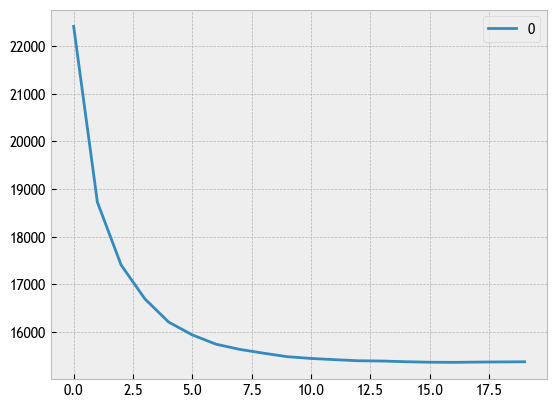

In [111]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

### Building Final KNN Model

In [112]:
knn = neighbors.KNeighborsRegressor(n_neighbors=11)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=11)

In [113]:
pred=knn.predict(X_train)
y_pred=knn.predict(X_test)

In [114]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 9193.54537805661
Mean Squared Error: 195519636.93174168
Root Mean Squared Error: 13982.833651722447


In [115]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 10134.256610492095
Mean Squared Error: 238281836.97993442
Root Mean Squared Error: 15436.380306922165


In [116]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.544499167609638
R-squared for Test: 0.4542184139133464


# Neural Network

In [117]:
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [118]:
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=1, input_dim=12))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae'])
    return regressor

In [119]:
regressor = KerasRegressor(build_fn=build_regressor, batch_size=256,epochs=10)

C:\Users\fatim\AppData\Local\Temp\ipykernel_15316\4242228616.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=build_regressor, batch_size=256,epochs=10)


In [120]:
results=regressor.fit(X_train,y_train)

Epoch 1/10
1153/1153 [==============================] - 3s 1ms/step - loss: 3120745472.0000 - mae: 39662.2773
Epoch 2/10
1153/1153 [==============================] - 1s 1ms/step - loss: 407957632.0000 - mae: 13603.7148
Epoch 3/10
1153/1153 [==============================] - 1s 1ms/step - loss: 402229984.0000 - mae: 13982.0430
Epoch 4/10
1153/1153 [==============================] - 1s 1ms/step - loss: 402180000.0000 - mae: 13984.5928
Epoch 5/10
1153/1153 [==============================] - 1s 1ms/step - loss: 402092672.0000 - mae: 13991.2568
Epoch 6/10
1153/1153 [==============================] - 1s 1ms/step - loss: 401964000.0000 - mae: 13995.9023
Epoch 7/10
1153/1153 [==============================] - 1s 1ms/step - loss: 401825280.0000 - mae: 14007.1279
Epoch 8/10
1153/1153 [==============================] - 1s 1ms/step - loss: 401623168.0000 - mae: 14014.2100
Epoch 9/10
1153/1153 [==============================] - 1s 1ms/step - loss: 401432096.0000 - mae: 14023.5137
Epoch 10/10
1153/1

In [121]:
pred= regressor.predict(X_train)
y_pred= regressor.predict(X_test)

495/495 [==============================] - 0s 879us/step


In [122]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 14024.834275354564
Mean Squared Error: 401061847.45224476
Root Mean Squared Error: 20026.52859215108


In [123]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 14065.5930274251
Mean Squared Error: 407411110.0889385
Root Mean Squared Error: 20184.427415434366


In [124]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.06564881041441828
R-squared for Test: 0.0668299159016904


### Voting Regressor

In [125]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
import warnings

In [126]:
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarning
reg1 = GradientBoostingRegressor(learning_rate=0.01, max_depth=6)
reg2 = RandomForestRegressor(max_depth=14,n_estimators=50, random_state=0)
reg3 = xgb.XGBRegressor(learning_rate=0.1, max_depth=4,objective='reg:squarederror')
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('xg', reg3)])
ereg = ereg.fit(X_train, y_train)

In [127]:
pred= ereg.predict(X_train)
y_pred= ereg.predict(X_test)

In [128]:
print('Train : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train : 
Mean Absolute Error: 4892.409348667071
Mean Squared Error: 53953349.85187797
Root Mean Squared Error: 7345.294401988117


In [129]:
print('Test : ')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test : 
Mean Absolute Error: 4986.7081368887175
Mean Squared Error: 57510560.713582516
Root Mean Squared Error: 7583.571764912792


In [130]:
print("R-squared for Train:",r2_score(y_train, pred))
print("R-squared for Test:",r2_score(y_test, y_pred))

R-squared for Train: 0.8743052301372749
R-squared for Test: 0.8682727754628019


# Save Model

In [131]:
import pickle
# Saving model to disk of random forest
pickle.dump(rfr, open('models/salesModel.pkl','wb'))

# Load Model and Predict

In [132]:
import pickle
model=pickle.load(open('models/salesModel.pkl', 'rb'))
model.predict([[211.2891429,19,1,2.514,0,2,151315,1,39.93,0,8.106,2010]])

C:\Users\fatim\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([28600.6489509])